env:[ML_39_TF]
# 构造双半月分类数据集，并使用KNN和MLP进行分类

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from plotly import express as px
import os

from tensorflow_estimator.python.estimator.keras_lib import model_to_estimator

os.environ["CUDA_VISIBLE_DEVICES"]="0"
X, y = make_moons(n_samples=411, noise=0.3)
moons = pd.DataFrame(pd.concat([pd.DataFrame(X,columns=['x1', 'x2']), pd.DataFrame(y,columns=["label"])], axis=1))

fig = px.scatter(moons,
                 x='x1',
                 y='x2',
                 color='label',
                 color_continuous_scale=['blue', 'red'],
                 title='散点图 - 不同标签用不同颜色表示')

fig.show()



## 1、使用KNN进行分类

KNN 预测准确度： 0.9197080291970803


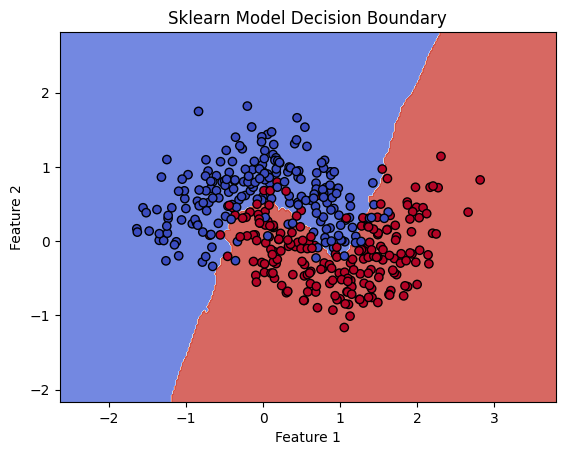

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from my_ML_tool import plot_decision_boundary


KNN = KNeighborsClassifier(n_neighbors=20)
KNN.fit(X,y)  # predict_centre为使用K_Means计算出来的中心，在这里相当于数据标签
# a = pd.DataFrame([5,5]).T

result = KNN.predict(X) # 转置之后才是 1行2列 的数据，或者使用KNN.predict(pd.array([5,5]))
print("KNN 预测准确度：", KNN.score(X,y))

import plotly.graph_objects as go

# 定义网格边界（稍微扩展数据范围以更好地显示边界）
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# 创建网格点
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 预测网格点的类别
Z = KNN.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


fig = go.Figure()

# 添加决策边界背景（使用等高线图）
fig.add_trace(go.Contour(
    x=np.arange(x_min, x_max, 0.02),
    y=np.arange(y_min, y_max, 0.02),
    z=Z,
    showscale=False,
    opacity=0.4,
    colorscale='Viridis'  # 可根据类别数调整颜色映射
))

# 添加原始数据点
fig.add_trace(go.Scatter(
    x=X[:, 0],
    y=X[:, 1],
    mode='markers',
    marker=dict(
        color=y,
        colorscale='Viridis',
        showscale=False
    ),
    showlegend=False
))

# 更新布局
fig.update_layout(
    title='KNN Decision Boundary',
    xaxis_title='Feature 1',
    yaxis_title='Feature 2'
)

# 显示图形
fig.show()

#
# print(result_cluster)

plot_decision_boundary(KNN,X,y)



## 2、使用MLP进行分类
### 2.1 检查GPU是否可用

In [3]:
import os
# 设置环境变量，指向 Conda CUDA DLL 所在目录
os.environ["PATH"] += os.pathsep + r"E:\Porject\python\conda_virtual_env\ML_309_tf\Library\bin"

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPU 是否可用：", gpus)

GPU 是否可用： [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

mlp = Sequential()
mlp.add(Dense(units=10,input_dim=2,activation="sigmoid"))
mlp.add(Dense(units=10,activation="sigmoid"))
mlp.add(Dense(units=10,activation="sigmoid"))
mlp.add(Dense(units=1,activation="sigmoid"))
mlp.summary()

mlp.compile(optimizer="adam",loss="binary_crossentropy",)

# os.environ["CUDA_VISIBLE_DEVICES"]="0" #如果要是GPU训练的话，这里要指定CUDA可视的设备编号
with tf.device('/GPU:0'):
    mlp.fit(X_train,y_train,epochs=3000, verbose=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## 3、查看训练的网络的 各节点的参数


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
第一层权重： [[ 0.6399202   0.644527   -0.64554584  0.55546004 -0.642281    0.64428216
   0.6272589   0.5794951  -0.6514816   4.281807  ]
 [-0.25495613 -0.2278014   0.25568128 -0.30758372  0.27176

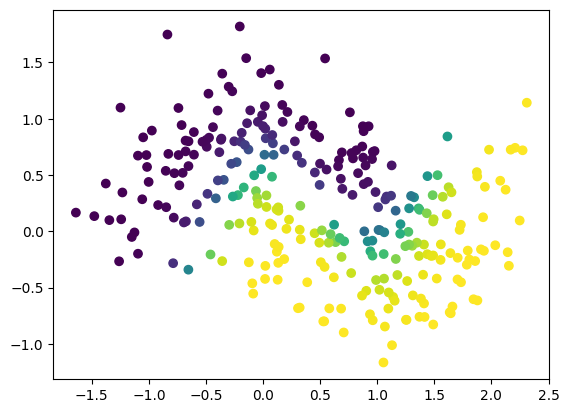

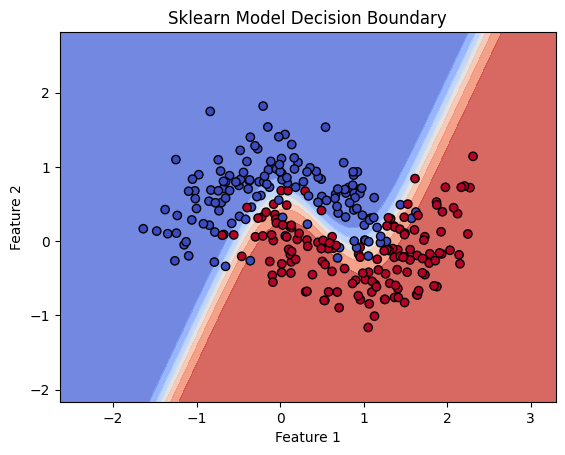

In [5]:
from sklearn.metrics import accuracy_score
from my_ML_tool import plot_decision_boundary

mlp.summary()

print("第一层权重：",mlp.layers[0].get_weights()[0])
print("第一层偏置：",mlp.layers[0].get_weights()[1])
print("第二层权重：",mlp.layers[1].get_weights()[0])
print("第二层偏置：",mlp.layers[1].get_weights()[1])

y_predict = mlp.predict(X_train)

print("准确度：",accuracy_score(y_train,np.where(y_predict>0.5,1,0)))
print("训练集损失值：",mlp.evaluate(X_train,y_train,verbose=1))
print("测试集损失值：",mlp.evaluate(X_test,y_test,verbose=1))

plt.scatter(X_train[:,0],X_train[:,1],c=y_predict)

plot_decision_boundary(mlp,X_train,y_train)
# plot_mlp_structure(mlp)


## 绘制MLP可视化

In [6]:
from my_ML_tool import plot_mlp_structure



# minst 数据集，进行手写数字识别

In [7]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()


## 展示部分数据

E:\ProgramData\anaconda3\envs\ML_39_TF\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.

E:\ProgramData\anaconda3\envs\ML_39_TF\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.

E:\ProgramData\anaconda3\envs\ML_39_TF\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.



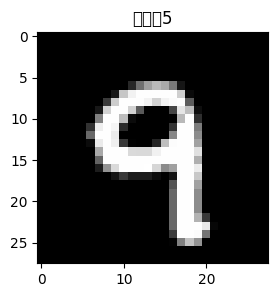

In [8]:
imag1 = X_train[4568]

fig1 = plt.figure(figsize=(3,3))
plt.imshow(imag1,cmap="gray")
plt.title(f"标签：{y_train[0]}")
plt.show()


## 将这些二维的数据进行预处理

In [9]:
format_X_train = X_train.reshape(-1,28*28) / 255.0
format_X_test = X_test.reshape(-1,28*28) / 255.0

from keras.utils import to_categorical  # 进行独热编码
format_y_train = to_categorical(y_train)
format_y_test = to_categorical(y_test)




## 建立模型

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation

mlp = Sequential()
mlp.add(Dense(units=392,input_dim=28*28,activation="sigmoid"))
mlp.add(Dense(units=392,activation="sigmoid"))
mlp.add(Dense(units=10,activation="softmax"))
mlp.summary()
mlp.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 392)               307720    
                                                                 
 dense_5 (Dense)             (None, 392)               154056    
                                                                 
 dense_6 (Dense)             (None, 10)                3930      
                                                                 
Total params: 465,706
Trainable params: 465,706
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [11]:
mlp.fit(format_X_train,format_y_train,epochs=10,verbose=1)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3504 - accuracy: 0.8963
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1441 - accuracy: 0.9566
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0920 - accuracy: 0.9720
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0660 - accuracy: 0.9793
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0477 - accuracy: 0.9847
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0361 - accuracy: 0.9885
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0265 - accuracy: 0.9911
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0216 - accuracy: 0.9929
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0162 - accuracy: 0.9949
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.014

# 卷积神经网络 (猫猫预测)

## 准备数据 处理图片和图片迭代器

In [12]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(r"E:\Porject\python\ML\dataset_self\cat_and_dog\8year_before\training_set\training_set",target_size=(50,50),batch_size=32,class_mode="binary") # 构建训练迭代器
val_set = train_datagen.flow_from_directory(r"E:\Porject\python\ML\dataset_self\animals",target_size=(50,50),batch_size=32,class_mode="binary")
#每张图片在输入网络前都会被缩放成 50×50 像素
#每次从文件夹里读取 32张图片 作为一个批次（batch）输入到模型。

Found 8005 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 构建一个卷积神经网络

In [28]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense
# import torch
# from tensorboardX import SummaryWriter
import time

model = Sequential()
# 卷积层
model.add(Conv2D(32,(3,3),input_shape=(50,50,3),activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#第二个卷积层、池化层
model.add(Conv2D(32,(3,3),activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flattening层
model.add(Flatten())


model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## 创建tensorboard可视化 回调函数

In [42]:

# # 运行一次前向传播
# x = tf.random.normal((1, 50, 50, 3))
# _ = model(x)
#
# tf.summary.trace_on(graph=True)
#
# with tf.device('/CPU:0'):
#     tf.summary.trace_export(
#         name="model_trace",
#         step=0,
#         profiler_outdir=log_path
#     )
#

import time
import os


log_path = "log_tensorboard/test/"+ time.strftime("%Y-%m-%d_%H_%M_%S")

writer = tf.summary.create_file_writer(log_path)
tf.summary.trace_on(graph=False, profiler=True)

# Create a callback
tf_callback = keras.callbacks.TensorBoard(    log_dir=log_path,
                                              write_graph=True,
    histogram_freq=1,      # 记录层权重分布
    embeddings_freq=1,     # 记录嵌入层可视化
    update_freq='batch',   # 每个 batch 更新一次日志（更实)
                                              )
print("运行以下命令启动 TensorBoard：")
print(f"tensorboard --logdir={os.path.abspath(log_path)}")

运行以下命令启动 TensorBoard：
tensorboard --logdir=E:\Porject\python\ML\ML_learn_test\log_tensorboard\test\2025-11-17_22_41_05


In [44]:
# os.system(f"tensorboard --logdir={os.path.abspath(os.path.dirname(log_path))}")
# 使用 Jupyter 的魔法命令，可以把tensorboard的窗口直接显示在Jupyter Notebook中
%load_ext tensorboard
%tensorboard --logdir $log_path --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25932), started 0:01:32 ago. (Use '!kill 25932' to kill it.)

In [16]:

import os

logdir = os.path.abspath(os.path.dirname(log_path))
os.system(f"start tensorboard --logdir={logdir}") # 改代码会打开一个黑乎乎的命令行窗口

0

## 训练模型

In [17]:

tf.keras.backend.clear_session()  # 关键：清除Keras后端的会话和变量
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
with tf.device('/GPU:0'):

    model.fit(training_set,epochs=20, callbacks=[tf_callback], validation_data=val_set)   # ✅ 指定验证集



Epoch 1/20
251/251 [==============================] - 79s 298ms/step - loss: 0.6547 - accuracy: 0.6037 - val_loss: 0.5158 - val_accuracy: 0.7630
Epoch 2/20
251/251 [==============================] - 12s 48ms/step - loss: 0.5706 - accuracy: 0.6966 - val_loss: 0.4965 - val_accuracy: 0.7420
Epoch 3/20
251/251 [==============================] - 12s 48ms/step - loss: 0.5146 - accuracy: 0.7427 - val_loss: 0.4851 - val_accuracy: 0.7590
Epoch 4/20
251/251 [==============================] - 12s 48ms/step - loss: 0.4765 - accuracy: 0.7764 - val_loss: 0.4246 - val_accuracy: 0.7930
Epoch 5/20
251/251 [==============================] - 12s 48ms/step - loss: 0.4428 - accuracy: 0.7971 - val_loss: 0.5276 - val_accuracy: 0.7540
Epoch 6/20
251/251 [==============================] - 12s 49ms/step - loss: 0.4085 - accuracy: 0.8115 - val_loss: 0.4432 - val_accuracy: 0.7910
Epoch 7/20
251/251 [==============================] - 12s 49ms/step - loss: 0.3616 - accuracy: 0.8362 - val_loss: 0.5505 - val_accuracy

In [18]:

# model.evalate(training_set)

## 预测
### 待预测图片预处理

In [19]:
from tensorflow.keras.preprocessing import image

img_path = "image/img_1.png"

# 加载图片，并调整到训练时的 target_size
img = image.load_img(img_path, target_size=(50, 50))

# 转成数组
img_array = image.img_to_array(img)

# 扩展维度，因为模型期望输入形状是 (batch_size, 50, 50, 3)
img_array = np.expand_dims(img_array, axis=0)

# 和训练时一样做归一化
img_array = img_array / 255.0

### 正式预测

In [20]:
print(training_set.class_indices) #获取猫狗的类别索引

prediction = model.predict(img_array)
print(prediction)


{'cats': 0, 'dogs': 1}
1/1 [==============================] - 0s 399ms/step
[[0.13500652]]


# VGG16模型进行fine-tune，猫狗预测
## 获取VGG16模型，去除最顶层

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_path = r"E:\Porject\python\ML\dataset_self\cat_and_dog\8year_before\training_set\training_set\cats\cat.1079.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)


model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg.trainable = False # 保持 ImageNet 学到的特征不变

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 添加自己的全连接层和softmax层

In [29]:

model_vgg_fine = Sequential([
    model_vgg,
    Flatten(),  # 将特征图展平
    Dense(10, activation='relu',input_dim=25088), # 添加全连接层
    Dropout(0.5), # 添加 Dropout 防止过拟合
    Dense(1, activation='sigmoid') # 输出层：类别数和 Softmax
])

print("\n--- 最终模型结构 ---")
model_vgg_fine.summary()


## ----------------------------------------------------
## 3. ⚙️ 配置和训练 (阶段 1: 仅训练分类器)
## ----------------------------------------------------

# 编译模型
model_vgg_fine.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', # 多分类损失
              metrics=['accuracy'])



--- 最终模型结构 ---
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                250890    
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 14,965,589
Trainable params: 250,901
Non-trainable params: 14,714,688
_________________________________________________________________


## 准备数据

In [33]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(r"E:\Porject\python\ML\dataset_self\cat_and_dog\8year_before\training_set\training_set",target_size=(224,224),batch_size=32,class_mode="binary") # 构建训练迭代器
val_set = train_datagen.flow_from_directory(r"E:\Porject\python\ML\dataset_self\animals",target_size=(224,224),batch_size=32,class_mode="binary")
#每张图片在输入网络前都会被缩放成 224*224 像素
#每次从文件夹里读取 32张图片 作为一个批次（batch）输入到模型。ry

Found 8005 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 创建tensorboard可视化 回调函数

In [36]:
import time
import os

log_path = "log_tensorboard/test/"+ time.strftime("%Y-%m-%d_%H_%M_%S")

writer = tf.summary.create_file_writer(log_path)
tf.summary.trace_on(graph=False, profiler=True)

# Create a callback
tf_callback = keras.callbacks.TensorBoard(    log_dir=log_path,
                                              write_graph=True,
    histogram_freq=1,      # 记录层权重分布
    embeddings_freq=1,     # 记录嵌入层可视化
    update_freq='batch',   # 每个 batch 更新一次日志（更实)
                                              )
print("运行以下命令启动 TensorBoard：")
print(f"tensorboard --logdir={os.path.abspath(log_path)}")

运行以下命令启动 TensorBoard：
tensorboard --logdir=E:\Porject\python\ML\ML_learn_test\log_tensorboard\test\2025-11-17_22_32_27


## 训练模型

In [ ]:

tf.keras.backend.clear_session()  # 关键：清除Keras后端的会话和变量
model_vgg_fine.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
# model_vgg_fine.compile(optimizer=Adam(learning_rate=1e-3),
#               loss='categorical_crossentropy', # 多分类损失
#               metrics=['accuracy'])

In [46]:
# 分割编译核训练的代码以用于多次训练
with tf.device('/GPU:0'):

    history_stage1 = model_vgg_fine.fit(
    training_set,
    steps_per_epoch=training_set.samples // 32,
    epochs=10,
    validation_data=val_set,
    validation_steps=val_set.samples // 32,
    callbacks=[tf_callback]
)


Epoch 1/10
250/250 [==============================] - 35s 139ms/step - loss: 1.1013 - accuracy: 0.7779 - val_loss: 0.3165 - val_accuracy: 0.9123
Epoch 2/10
250/250 [==============================] - 34s 136ms/step - loss: 0.8170 - accuracy: 0.7487 - val_loss: 0.3162 - val_accuracy: 0.8942
Epoch 3/10
250/250 [==============================] - 34s 136ms/step - loss: 0.7905 - accuracy: 0.7268 - val_loss: 0.3267 - val_accuracy: 0.8800
Epoch 4/10
250/250 [==============================] - 34s 135ms/step - loss: 0.7090 - accuracy: 0.7281 - val_loss: 0.3153 - val_accuracy: 0.8871
Epoch 5/10
250/250 [==============================] - 35s 141ms/step - loss: 0.7248 - accuracy: 0.7179 - val_loss: 0.3126 - val_accuracy: 0.8901
Epoch 6/10
250/250 [==============================] - 37s 148ms/step - loss: 0.6421 - accuracy: 0.7271 - val_loss: 0.3024 - val_accuracy: 0.9042
Epoch 7/10
250/250 [==============================] - 35s 139ms/step - loss: 0.6343 - accuracy: 0.7265 - val_loss: 0.2969 - val_ac

In [1]:
%load_ext tensorboard
%tensorboard --logdir $log_path --port 6006

In [2]:
%reload_ext tensorboard
%tensorboard --logdir $log_path --port 6006


Reusing TensorBoard on port 6006 (pid 34800), started 0:00:04 ago. (Use '!kill 34800' to kill it.)

In [44]:


x = np.expand_dims(img,axis=0)
x = preprocess_input(x)
print(model_vgg.summary())

features = model_vgg.predict(x)
print(features.shape)


features = features.reshape(features.shape[0], -1)
print(features.shape)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [45]:
print(model_vgg.weights[0])


<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355